In [ ]:
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_docling import DoclingLoader
from langchain_openai import AzureChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from pydantic_core import core_schema
from typing import Annotated, Any, Dict, List, Literal, TypedDict

import asyncio
import docx
import getpass
import html
import json
import logging
import mimetypes
import operator
import os
import re
import time

In [ ]:
# Load environment variables from .env file
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("AZURE_OPENAI_ENDPOINT")
_set_env("AZURE_OPENAI_API_KEY")
_set_env("AZURE_OPENAI_DEPLOYMENT_NAME")
_set_env("AZURE_OPENAI_MODEL_NAME")
_set_env("AZURE_OPENAI_API_VERSION")
_set_env("REPROMPTING")
_set_env("MAX_PROMPTS")
_set_env("CHUNK_SIZE")
_set_env("CHUNK_OVERLAP")

REPROMPTING = os.environ["REPROMPTING"].casefold() == "true"
MAX_PROMPTS = int(os.environ["MAX_PROMPTS"])

CHUNK_SIZE = int(os.environ["MAX_PROMPTS"])
CHUNK_OVERLAP = int(os.environ["CHUNK_OVERLAP"])

In [ ]:
llm = AzureChatOpenAI(model=os.environ["AZURE_OPENAI_MODEL_NAME"], api_version=os.environ["AZURE_OPENAI_API_VERSION"], temperature=0.1)

In [ ]:
system_prompt = '''
    You are a GDPR-compliant data privacy assistant. Your role is to detect Personally Identifiable Information (PII) in provided text based on the EU’s General Data Protection Regulation (GDPR).

    PII includes any information relating to an identified or identifiable natural person, either directly (e.g., name, email address, national ID number) or indirectly (e.g., IP address, location data, unique device identifiers, or any data that can identify a person when combined with other information).

    When analyzing documents, you must:
    1. Identify and extract all PII instances.
    2. Categorize each instance.
    3. Determine if it is a direct or indirect identifier.
    4. Justify the classification based on GDPR definitions.

    Maintain strict compliance with GDPR’s definition of personal data as described in Article 4(1).

    Output results in structured JSON array format, suitable for downstream processing.
    If no PII is identified, return an empty JSON array.
'''

user_prompt_template = '''
    ### Instruction:
    Analyze the following document and identify all instances of Personally Identifiable Information (PII) according to the EU's GDPR.

    ### Input:
    {text}

    ### Response:
    For each identified PII instance, return the:
    - text: The extracted text, exactly as it appears in the document
    - category: The PII category (e.g., name, email, phone number, IP address, health data)
    - type: The PII identifier type (direct or indirect)
    - justification: The justification for PII classification

    Output results in structured JSON array format, where each object in the array represents a PII instance.
    If no PII is identified, return an empty JSON array.

    Example:
    [
        {{"text": "John Doe", "category": "name", "type": "direct", "justification": "Identifies an individual directly."}},
        {{"text": "d.joe@brand.co", "category": "email", "type": "direct", "justification": "Identifies an individual directly through their email address."}}
    ]
'''

combination_prompt_template = '''
    ### Instruction:
    You are given a list of structured JSON arrays of JSON objects, where each object in the array represents a Personally Identifiable Information (PII) instance.

    Each PII JSON object contains the following attributes:
    - text
    - category
    - type
    - justification

    Merge all arrays into a single final JSON array which contains all the JSON objects.

    ### Input:
    {pii_lists}

    ### Response:
    Output result in structured JSON array format, where each object in the array represents a PII instance.
'''

In [ ]:
map_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", user_prompt_template),
    ]
)

reduce_prompt  = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", combination_prompt_template),
    ]
)

In [ ]:
class OIFile:
    '''
    This is a class for representing a user-uploaded document
    object. It stores the document ID, the document name, the
    document mimetype, the document content and the content summary.
    '''
    def __init__(self, id: str, name: str, type: str, content: str):
        self.id = id
        self.name = name
        self.type = type
        self.content = self._build_content(content)

    def get_id(self) -> str:
        return self.id

    def get_name(self) -> str:
        return self.name

    def get_type(self) -> str:
        return self.type

    def get_content(self) -> str:
        return self.content

    def get_size(self) -> int:
        return len(self.content)

    def set_content(self, content: str) -> None:
        self.content = content

    def _build_content(self, text_content: str) -> str:
        text = ''

        if text_content:
            text = text_content

            # Step 1: Remove HTML comments
            text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

            # Step 2: Remove HTML comments (duplicate step in original code)
            text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

            # Step 3: Remove HTML tags
            text = re.sub(r'<[^>]+>', '', text)

            # Step 4: Decode HTML entities like &nbsp;
            text = html.unescape(text)

            # Step 5: Fix spacing issues
            # Normalize multiple spaces
            text = re.sub(r' +', ' ', text)

            # Normalize newlines (no more than two consecutive)
            text = re.sub(r'\n{3,}', '\n\n', text)

            # Step 6: Fix specific layout issues from the document
            # Fix broken lines that should be together (like "Αριθμός Γ.Ε.ΜΗ .: 180526838000")
            text = re.sub(r'([a-zA-Zα-ωΑ-Ω])\.\s+:', r'\1.:', text)

            # Step 7: Remove extra spaces before punctuation
            text = re.sub(r' ([.,:])', r'\1', text)

            # Clean up trailing whitespace on each line
            text = '\n'.join(line.rstrip() for line in text.splitlines())

            # Clean up whitespaces at the beginning and ending of each string
            text.strip()

        return text

    def __repr__(self) -> str:
        return f"File(id={self.id}, name={self.name}, type={self.type}, size={len(self.content)} bytes)"

    @classmethod
    def __get_pydantic_core_schema__(
        cls, _source_type: Any, _handler: Any
    ) -> core_schema.CoreSchema:
        """Tell Pydantic how to serialize/deserialize OIFile objects."""
        return core_schema.union_schema([
            # Handle OIFile instance
            core_schema.is_instance_schema(OIFile),
            # Convert dict to OIFile
            core_schema.chain_schema([
                core_schema.dict_schema(),
                core_schema.no_info_plain_validator_function(
                    lambda d: OIFile(
                        id=d.get("id"),
                        name=d.get("name"),
                        type=d.get("type"),
                        content=d.get("content"),
                    )
                ),
            ]),
        ])

    def to_dict(self) -> dict:
        """Convert OIFile instance to a dictionary."""
        return {
            "id": self.id,
            "name": self.name,
            "type": self.type,
            "content": self.content,
        }

In [ ]:
class InputState(TypedDict):
    files: List[dict]

class OverallState(TypedDict):
    n_prompts: Annotated[int, lambda a, b: max(a, b)]
    documents: Annotated[List[OIFile], operator.add]
    document_chunks: Annotated[Dict[str, List[str]], operator.or_]
    document_ids: Annotated[List[str], operator.add]
    partial_pii_items: Annotated[List[str], operator.add]
    document_partial_pii_items: Dict[str, List[str]]
    collected_pii_items: Dict[str, str]

class OutputState(TypedDict):
    final_pii_items: List[dict[str, Any]]


class LoadState(TypedDict):
    """State for the load node that contains a file information to be loaded as an IOFile object."""
    file: Dict[str, Any]

class SplitState(TypedDict):
    """State for the split node that contains an IOFile object whose content will be split into chunks."""
    document: OIFile

class DetectState(TypedDict):
    """State for the detect node that contains a document and a list of PII items to detect in the document content."""
    n_prompts: int
    document_id: str
    content: str

class MaskState(TypedDict):
    """State for the mask node that contains an document and a list of PII items to mask in the document content."""
    document: OIFile
    pii_items: List[str]

class MaskCollectState(TypedDict):
    """State for collecting masked chunks."""
    n_prompts: int
    masked_document_chunks: Dict[str, List[str]]
    masked_chunk: Dict[str, Any]

In [ ]:
# Validate the logger name
logger_name = os.environ.get("LOGGER_NAME", "pii-detector-map-reduce")

if not isinstance(logger_name, str) or not logger_name.strip():
    raise ValueError("Logger name must be a non-empty string.")

# Get or create a logger with the specified name
logger = logging.getLogger(logger_name)

# Ensure the logger is not already configured
if not logger.hasHandlers():
    # If the logger does not have handlers, we will set it up
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        fmt="%(asctime)s %(levelname)s %(name)s: %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    )
    handler.setFormatter(formatter)
    logger.addHandler(handler)

logger.setLevel(logging.DEBUG)

In [ ]:
async def chunk_document(
    document: OIFile,
    chunk_size: int = CHUNK_SIZE,
    chunk_overlap: int = CHUNK_OVERLAP,
) -> tuple:
    if document.get_content():
        print(f"DOCUMENT: {document}")

        # Create a text splitter to split the document into smaller chunks
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1024,
            chunk_overlap=128,
            separators=["\n\n", "\n", ". ", "! ", "? ", "; ", ": ", ", ", "... ", " ", ""],
            is_separator_regex=False
        )

        # Split the documents into smaller chunks
        chunks = text_splitter.split_text(document.get_content())

        # Get the number of documents created after splitting
        num_chunks = len(chunks)

        if num_chunks == 0:
            print(f"✕ {document.get_name()}: ERROR: No documents were created after splitting. Check input text and chunk size.")
        else:
            print(f"✓ {document.get_name()}: Generated {num_chunks} documents.")

    return chunks

In [ ]:
# First, add debug output to _map_input to track files found
def _map_input(state: InputState) -> list[OIFile]:
    """Load documents from a specified directory."""
    sends = []
    path = state.get('path', 'documents')

    if os.path.exists(path):
        file_paths = [os.path.join(path, f) for f in os.listdir(path)
                     if f.casefold().endswith('.docx') or f.casefold().endswith('.pdf')]

        print(f"Found {len(file_paths)} files: {[os.path.basename(f) for f in file_paths]}")

        if file_paths:
            for id, path in enumerate(file_paths):
                sends.append(
                    Send("load_document", {
                        "id": id+1,
                        "path": path,
                    })
                )

    return sends

In [ ]:
async def _load_document(state: LoadState) -> OverallState:
    """Load a document from the provided file information dictionary."""
    results = []

    id = state.get('id', '')
    path = state.get('path', '')

    # Add better error handling and debugging
    try:
        if path and isinstance(path, str) and os.path.exists(path) and os.path.isfile(path):
            documents = DoclingLoader(file_path=path).load()

            # Extract the file name and content
            fid = str(id)
            fname = os.path.basename(path)
            fcontent = '\n'.join([d.page_content for d in documents])

            ftype, _ = mimetypes.guess_type(path)
            if not ftype:
                ftype = 'application/octet-stream'

            results.append(OIFile(id=fid, name=fname, type=ftype, content=fcontent))

            logger.debug(f"✓ Successfully loaded document: {results[0]}")
        else:
            logger.error(f"✕ ERROR: Wrong or missing file path for document with ID {id}")
    except Exception as e:
        logger.error(f"✕ ERROR: Could not load document: {str(e)}")

    return {'documents': results}

In [ ]:
async def _map_documents_to_split(state: OverallState) -> SplitState:
    """Map loaded documents to split_document state."""
    sends = []

    for doc in state.get('documents', []):
        sends.append(
            Send("split_document", {
                "document": doc,
            })
        )

    return sends

In [ ]:
async def _split_document(state: SplitState) -> OverallState:
    """Split a document into chunks."""
    results = {}

    file = state.get('document', None)

    if file:
        logger.debug(f"Splitting document: {file}")

        chunks = await chunk_document(file)

        if chunks:
            # Store chunks in dictionary with file ID as key
            results[file.get_id()] = list(chunks)

            logger.debug(f"✓ Successfully split document {file.get_name()} into {len(chunks)} chunks")
        else:
            logger.warning(f"⚠ WARNING: No chunks generated for document {file.get_name()}")
    else:
        logger.error("✕ ERROR: No document provided to '_split_document'")

    return {'document_chunks': results}

In [ ]:
async def _map_chunks(state: OverallState) -> DetectState:
    """Map document chunks to identify_pii_items state."""
    sends = []

    n_prompts = state.get("n_prompts", 0)
    files_chunks = state.get('document_chunks', {})

    logger.debug(f"Map chunks received: {len(files_chunks)} documents")

    # For each document in the chunked_documents
    for file_id, chunks in files_chunks.items():
        logger.debug(f"Processing document {file_id} with {len(chunks)} chunks")

        # Log the content of the first chunk for debugging
        if chunks:
            logger.debug(f"First chunk sample: {chunks[0][:100]}...")

        # For each chunk in the document
        for content in chunks:
            # Create Send objects with document index metadata
            sends.append(
                Send("identify_pii_items",
                    {
                        "n_prompts": n_prompts,
                        "document_id": file_id,
                        "content": content,
                    }
                )
            )

    return sends

In [ ]:
async def _identify_pii_items(state: DetectState) -> OverallState:
    """Identify PII items in the provided document content using an LLM."""
    results = {}

    n_prompts = state.get("n_prompts", 0)
    file_id = state.get("document_id", "")
    text = state.get("content", "")

    if file_id and text:
        prompt = await map_prompt.ainvoke({'text': text})
        response = await llm.ainvoke(prompt)
        content = response.content

        # Log the raw LLM response
        logger.debug(f"Raw LLM response for PII detection: {content}")

        if content.startswith("```json\n") and content.endswith("\n```"):
            content = content.replace("```json\n", "").replace("\n```", "").strip()

        # Also log the processed content
        logger.debug(f"Processed JSON content: {content}")

        results.update({
            "n_prompts": n_prompts + 1,
            "document_ids": [file_id],
            "partial_pii_items": [content],
        })

    return results

In [ ]:
async def reprompt_to_identify_more_pii_items(state: OverallState) -> Literal["split_documents", "organize_pii_by_file"]:
    if REPROMPTING and state.get("n_prompts", 0) < MAX_PROMPTS:
        return "split_documents"
    else:
        return "organize_pii_by_file"

In [ ]:
async def _group_pii_by_file(state: OverallState):
    """ Groups identified PII items by file ID for further processing."""
    results = {}

    # FIXED: Use document_ids instead of file_ids
    for file_id, items in zip(state.get("document_ids", []), state.get("partial_pii_items", [])):
        results.setdefault(file_id, []).append(items)

    logger.debug(f"Grouped PII by file: {results}")

    return {"document_partial_pii_items": results}

In [ ]:
async def _should_reprompt(state: OverallState) -> Literal["mask_documents", "combine_file_pii_items"]:
    """ Determines whether to reprompt based on the current number of prompts."""
    logger.debug(f"N_PROMPTS: {state.get('n_prompts', 0)}")

    if REPROMPTING and state.get("n_prompts", 0) < MAX_PROMPTS:
        return "mask_documents"
    else:
        return "combine_file_pii_items"

In [ ]:
async def _mask_documents(state: OverallState) -> OverallState:
    """
    Prepares document chunks and PII items for masking.

    Args:
        state: OverallState containing document chunks and PII items

    Returns:
        Updated state with masked chunks collection
    """
    # Initialize a collection for all chunks
    masked_chunks = {}

    files_chunks = state.get('document_chunks', {})

    if files_chunks:
        for file_id, chunks in files_chunks.items():
            # Start with copies of original chunks
            masked_chunks[file_id] = chunks.copy()

    return {"document_chunks": masked_chunks}

In [ ]:
async def _route_masked_documents(state: OverallState) -> Literal["mask_text", "collect_masked_chunks"]:
    """
    Routes documents to either masking (if PII found) or directly to collection.
    """
    files_chunks = state.get('document_chunks', {})
    files_pii_items = state.get('document_partial_pii_items', {})

    # Check if any chunks need masking
    needs_masking = False
    if files_chunks and files_pii_items:
        for file_id, chunks in files_chunks.items():
            for chunk_idx, chunk in enumerate(chunks):
                if file_id in files_pii_items and chunk_idx < len(files_pii_items[file_id]):
                    pii_items = files_pii_items[file_id][chunk_idx]
                    if any(pii_item in chunk for pii_item in pii_items):
                        needs_masking = True
                        break
            if needs_masking:
                break

    # Route based on whether any chunks need masking
    if needs_masking:
        return "mask_text"
    else:
        return "collect_masked_chunks"

In [ ]:
async def _mask_text(state: MaskState) -> OverallState:
    """
    Mask the content of a document based on previously identified PII items.
    This function replaces PII items with asterisks and updates the document collection.

    Args:
        state: MaskState containing document ID, content, and PII items

    Returns:
        Dictionary with the masked chunk and updated document chunks
    """
    results = {}

    file_id = state.get('document_id', "")
    text = state.get('content', '')
    pii_items = state.get('pii_items', [])
    chunk_index = state.get('chunk_index', 0)

    if file_id and text and pii_items and chunk_index is not None:
        # Create a new masked version of the text (fixing the replacement issue)
        masked_text = text
        for item in pii_items:
            masked_text = masked_text.replace(item, "*" * len(item))

        results.update({
            "masked_chunk": {
                "file_id": file_id,
                "chunk_index": chunk_index,
                "content": masked_text
            }
        })

    # Return with masked chunk that will update the document collection
    return results

In [ ]:
async def _collect_masked_chunks(state: MaskCollectState):
    """ Collects masked document chunks and increments the n_prompts counter."""
    results = {}

    n_prompts = state.get('n_prompts', 0)  # Get current n_prompts value
    document_chunks = state.get('document_chunks', {})  # Use document_chunks instead of masked_document_chunks
    masked_chunk = state.get('masked_chunk', {})

    # If we have a new masked chunk, update our collection
    if document_chunks and masked_chunk:
        file_id = masked_chunk.get('file_id', '')
        chunk_index = masked_chunk.get('chunk_index', 0)
        content = masked_chunk.get('content', '')

        if file_id and file_id in document_chunks:
            # Update the specific chunk with masked content
            if chunk_index < len(document_chunks[file_id]):
                document_chunks[file_id][chunk_index] = content

        # Always set these values to ensure consistent state structure
        results.update({
            "document_chunks": document_chunks if document_chunks else {},
            "n_prompts": n_prompts + 1 if document_chunks and masked_chunk else n_prompts
        })

    return results

In [ ]:
async def _combine_file_pii_items(state: OverallState):
    """ Combines identified PII items from different chunks of the same document into a single structured output."""
    results = {}

    for file_id, pii_items in state.get('document_partial_pii_items', {}).items():
        try:
            # FIXED: Safely handle JSON parsing
            pii_lists = []
            for pii_item in pii_items:
                try:
                    # Try to parse if it's a string
                    if isinstance(pii_item, str):
                        parsed_item = json.loads(pii_item)
                        pii_lists.append(json.dumps(parsed_item))
                    else:
                        # Already an object
                        pii_lists.append(json.dumps(pii_item))
                except json.JSONDecodeError:
                    logger.warning(f"Could not parse PII item: {pii_item[:100]}...")

            # Join the items for the prompt
            joined_lists = ',\n        '.join(pii_lists)

            # Generate the prompt and get LLM response
            prompt = await reduce_prompt.ainvoke({'pii_lists': joined_lists})
            response = await llm.ainvoke(prompt)
            content = response.content

            if content.startswith("```json\n") and content.endswith("\n```"):
                content = content.replace("```json\n", "").replace("\n```", "").strip()

            results[file_id] = content

            logger.debug(f"Combined PII for {file_id}: {content}")

        except Exception as e:
            logger.error(f"Error combining PII for file {file_id}: {str(e)}")

    return {'collected_pii_items': results}

In [ ]:
async def _postprocess_pii_items(state: OverallState):
    '''
    Post-processes the collected PII items to remove duplicates based on 'text' and 'category' keys.
    '''
    results = []

    # Debug logging
    logger.debug(f"Postprocessing PII items from: {state}")

    # Access the correct key from the state
    collected_items = state.get('collected_pii_items', {})
    logger.debug(f"Collected items: {collected_items}")

    for file_id, pii_items in collected_items.items():
        try:
            # Parse JSON string to object
            logger.debug(f"Processing PII items for file {file_id}: {pii_items[:100]}...")

            # Handle both string and already parsed objects
            if isinstance(pii_items, str):
                parsed_items = json.loads(pii_items)
            else:
                parsed_items = pii_items

            logger.debug(f"Parsed items type: {type(parsed_items)}")

            # Remove duplicates based on 'text' and 'category' fields
            unique_items = set()
            unique_pii_items = []

            for item in parsed_items:
                # Create a hashable key from the 'text' and 'category' fields
                item_key = f"{item.get('text', '')}_{item.get('category', '')}"

                # Only add items we haven't seen before
                if item_key not in unique_items:
                    unique_items.add(item_key)
                    unique_pii_items.append(item)

            results.append(
                {
                    "id": file_id,
                    "pii": unique_pii_items,
                }
            )

            logger.debug(f"Added {len(unique_pii_items)} unique PII items for file {file_id}")

        except json.JSONDecodeError as e:
            logger.error(f"Error parsing PII items for file {file_id}: {e}")
            logger.error(f"Raw content: {pii_items}")
        except Exception as e:
            logger.error(f"Error processing PII items for file {file_id}: {e}")
            import traceback
            logger.error(traceback.format_exc())

    logger.debug(f"Final results: {results}")
    return {'final_pii_items': results}

In [ ]:
# Define the graph
builder = StateGraph(OverallState, input=InputState, output=OutputState)

# Add nodes with async functions
builder.add_node("load_document", _load_document)
builder.add_node("split_document", _split_document)
builder.add_node("identify_pii_items", _identify_pii_items)
builder.add_node("group_pii_by_file", _group_pii_by_file)
builder.add_node("mask_documents", _mask_documents)
builder.add_node("mask_text", _mask_text)
builder.add_node("collect_masked_chunks", _collect_masked_chunks)
builder.add_node("combine_file_pii_items", _combine_file_pii_items)
builder.add_node("postprocess_pii_items", _postprocess_pii_items)

# Add edges (with or without conditional routing)
builder.add_conditional_edges(START, _map_input, ["load_document"])
builder.add_conditional_edges("load_document", _map_documents_to_split, "split_document")
builder.add_conditional_edges("split_document", _map_chunks, ["identify_pii_items"])
builder.add_edge("identify_pii_items", "group_pii_by_file")
builder.add_conditional_edges("group_pii_by_file", _should_reprompt, ["mask_documents", "combine_file_pii_items"])
builder.add_conditional_edges("mask_documents", _route_masked_documents, ["mask_text", "collect_masked_chunks"])
builder.add_edge("mask_text", "collect_masked_chunks")
builder.add_conditional_edges("collect_masked_chunks", _map_chunks, ["identify_pii_items"])
builder.add_edge("combine_file_pii_items", "postprocess_pii_items")
builder.add_edge("postprocess_pii_items", END)

# Compile the graph
graph = builder.compile(
    interrupt_before=[],
    interrupt_after=[],
)
graph.name = "PiiDetectionLangGraph"

# Create main agent instance
app = graph

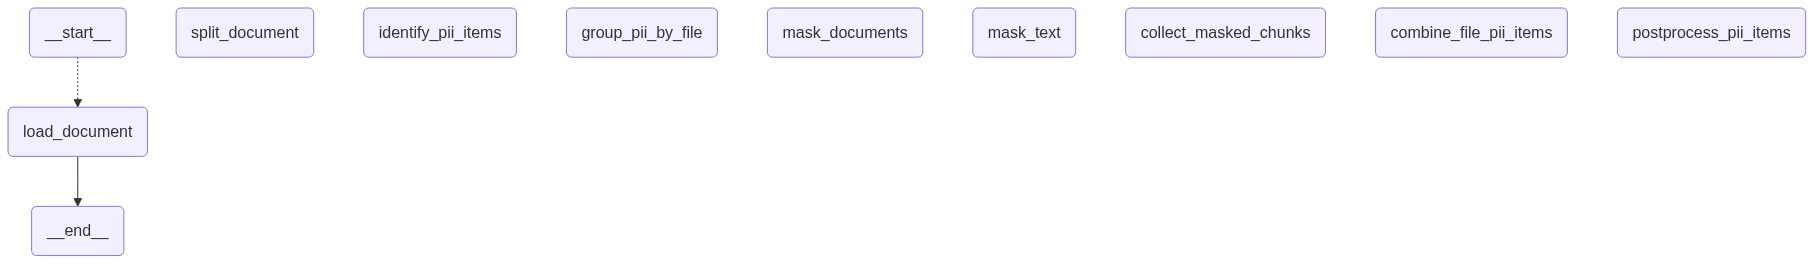

In [26]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": 1, "recursion_limit": 30}}

In [ ]:
last_step = None
async for step in app.astream(
    {'files': 'documents'},
    {"recursion_limit": 20},
):
    print(list(step.keys()))
    last_step = step

In [ ]:
last_step['postprocess_pii_items']['final_pii_items']